In [1]:
# Train a CNN regression to predict the mCG level of all DMRs
import pandas as pd
import csv
import numpy as np
import time
import matplotlib.pyplot as plt
import seqlogo

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# Load DMR mCG levels
dmrs_mc = pd.read_csv('/cndd/emukamel/snmCSeq/DMR/Kmer_Features/Mouse_DMRs_methylation_level.csv',
                  names=['Clust%d' % i for i in range(15)], header=None, index_col=False)
dmrs_mc = torch.tensor(dmrs_mc.to_numpy(), dtype=torch.float)

In [3]:
ndmrs, ncelltypes = dmrs_mc.shape
dmrs_mc[0]

tensor([0.8448, 0.9286, 0.8721, 0.1053, 0.3000, 0.8077, 0.9643, 0.9423, 0.9597,
        0.9688, 0.9574, 0.8667, 0.9426, 0.8919, 0.9592])

In [4]:
datadir = '/cndd/emukamel/snmCSeq/DMR'
seq_fn = datadir+'/mouse_all_cluster_dms2_HighVariance.fasta'
seqs = pd.read_csv(seq_fn, index_col = False, header=None, sep="\t")
max_seqlength = max([len(i) for i in seqs[1]])

In [5]:
# One-hot encoding of the sequences
seqs[1] = seqs[1].str.upper()
acgt = 'NACGT'

acgt_to_int = dict((n,i) for i,n in enumerate(acgt))

seqs_1hot = np.zeros(shape=(seqs.shape[0],max_seqlength,len(acgt)), dtype=np.int8) 
for js,seq in enumerate(seqs[1]):
    for jlett,lett in enumerate(seq):
        seqs_1hot[js,jlett,acgt_to_int[lett]] = 1

In [6]:
# Convert to tensor
seqs_1hot_tensor = torch.tensor(seqs_1hot)

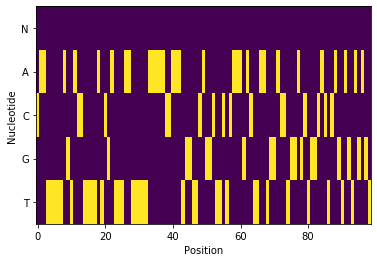

In [10]:
plt.imshow(seqs_1hot[1,1:100,:].transpose(), aspect='auto')
plt.ylabel('Nucleotide')
plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
plt.xlabel('Position')
plt.show()

In [133]:
# Define the neural net architecture
window = max_seqlength
nfilt = 128;
filt_width = 15

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(5, nfilt, filt_width)
        self.pool = nn.MaxPool1d(window-filt_width)
        self.fc1 = nn.Linear(nfilt, nfilt)
        self.fc2 = nn.Linear(nfilt, ncelltypes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))).squeeze()
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()

In [134]:
# net(batch_X)
# print(batch_X.shape)
# x1=net.pool(F.relu(net.conv1(batch_X))).squeeze()
# print(x1.shape)
# nl = nn.Linear(128, 5)
# print(nl(x1).shape)
# # x2 = nl(x1)

In [135]:
# Define loss and optimization parameters
criterion = nn.MSELoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [205]:
from IPython.display import clear_output
from matplotlib import pyplot as plt
import collections
%matplotlib inline

# def live_plot(data_dict, figsize=(7,5), title=''):
#     clear_output(wait=True)
#     plt.figure(figsize=figsize)
#     for label,data in data_dict.items():
#         plt.plot(data, label=label)
#     plt.title(title)
#     plt.grid(True)
# #     plt.xlabel('epoch')
# #     plt.legend(loc='center left') # the plot evolves to the right
#     plt.show();

data = collections.defaultdict(list)
for i in range(100):
    data['foo'].append(np.random.random())
    data['bar'].append(np.random.random())
    data['baz'].append(np.random.random())
    live_plot(data)

KeyboardInterrupt: 

In [203]:
fig,ax=plt.subplots()
ax.plot([1,2,3],'o-')
for i in range(10):
#     ax.clear()
    ax.lines[0].set_ydata(range(i+2))
    fig.canvas.draw()
# #     fig.canvas.flush_events()
#     time.sleep(0.2)
#     print(i)
# # ax.clear()
# # plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

ValueError: shape mismatch: objects cannot be broadcast to a single shape

<Figure size 432x288 with 1 Axes>

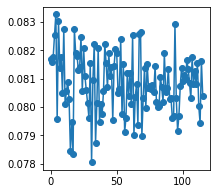

Finished Training


In [206]:
# Run the training
net.train
batch_size = 2**10
running_time = 0
X = seqs_1hot_tensor
all_loss = []
figsize=(3,3)
# X = seqs_1hot_tensor[0:1000,:,:]
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    permutation = torch.randperm(X.size()[0])
    start=time.time()
    for i in range(0, X.size()[0], batch_size):
        indices = permutation[i:i+batch_size]
        batch_X = X[indices,:,:].float()
        
        # Input should be of size: (batch, channels, samples)
        batch_X = torch.transpose(batch_X,2,1)
        batch_dmrs_mc = dmrs_mc[indices]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_X)
        loss = criterion(outputs, batch_dmrs_mc)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        all_loss.append(loss.item())
        if (time.time()-start)>0:
            # print statistics
            clear_output(wait=True)

            running_time += time.time()-start
            print('[Epoch %d, Item %d/%d, %3.1f%% of data] loss: %.3g; Total time: %3.2fs' %
                  (epoch + 1, i, ndmrs, 100*i/ndmrs, np.mean(all_loss), running_time))
            running_loss = 0.0
            start = time.time()
            
            plt.figure(figsize=figsize)
            plt.plot(all_loss,'o-')
            plt.xlabel('Batches')
            plt.ylabel('MSE')
            plt.show()

            
print('Finished Training')

In [150]:
# Compare predicted with actual DMR mCG level
X = torch.transpose(seqs_1hot_tensor.float(),2,1)
dmr_hat=np.zeros((ndmrs,ncelltypes))
net.eval()
batch_size = 2**12
start = time.time()
test_points = torch.randperm(X.size()[0])[0:1000]
for i in range(0, test_points.shape[0], batch_size):
    indices = test_points[i:i+batch_size]
#     range(i, min(test_points.shape[0],i+batch_size))
    dmr_hat[indices] = net(X[indices]).detach().numpy()
    print('Iter %d, %f s' % (i, time.time()-start))
print('Done; %fs' % (time.time()-start))

58959
Iter 0, 1.292788 s
Done; 1.292942s


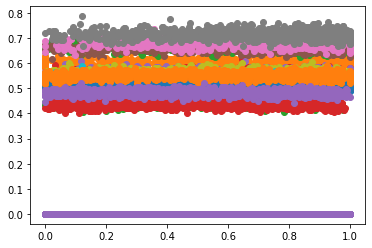

In [151]:
plt.plot(dmrs_mc, dmr_hat,'o');

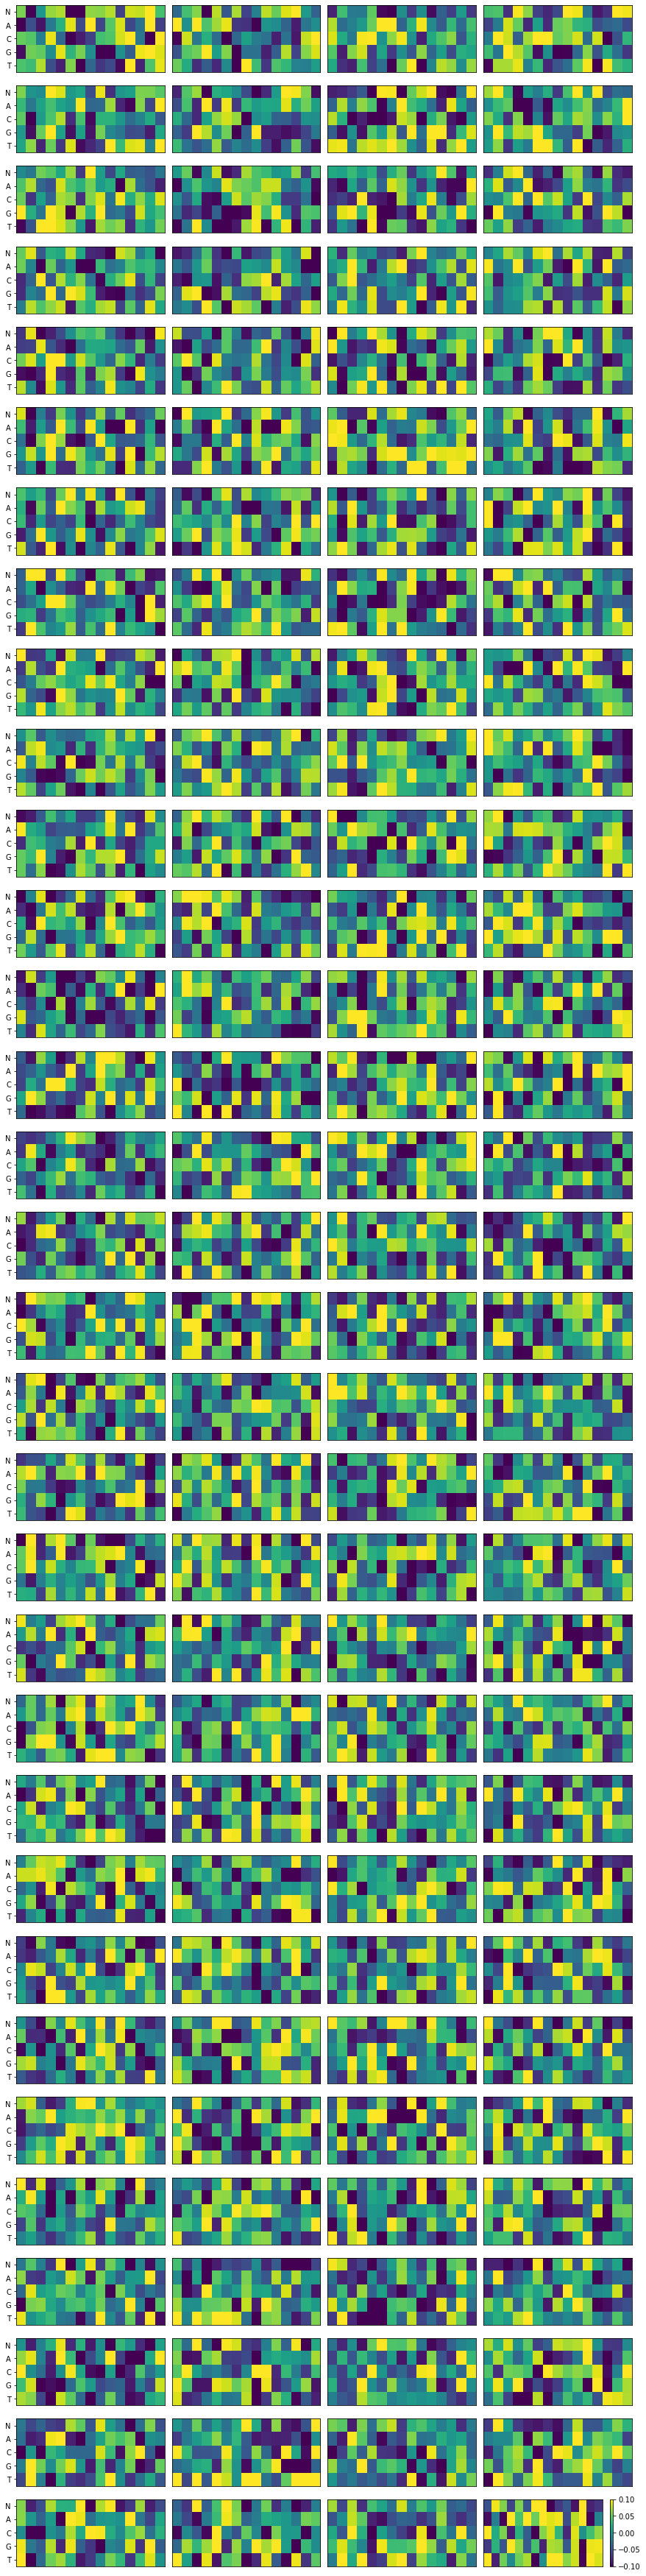

In [152]:
# Visualize the weight matrices
weights = net.state_dict()['conv1.weight'].numpy()
plt.figure(figsize=(15,2*128/4))
for jfeature in range(weights.shape[0]):
    plt.subplot(128/4,4,jfeature+1,xmargin=-0.4)
    weight = weights[jfeature,:,:].squeeze()
    plt.imshow(weight, aspect='auto', vmin=-.1,vmax=.1)
    plt.xticks([])
    if (jfeature % 4 ==0):
        plt.yticks(list(acgt_to_int.values()),list(acgt_to_int.keys()))
    else:
        plt.yticks([])
#     if jfeature>5:
#         break

plt.subplots_adjust(wspace=0.05)
plt.colorbar();
# plt.show()

In [36]:
10%4==1

False

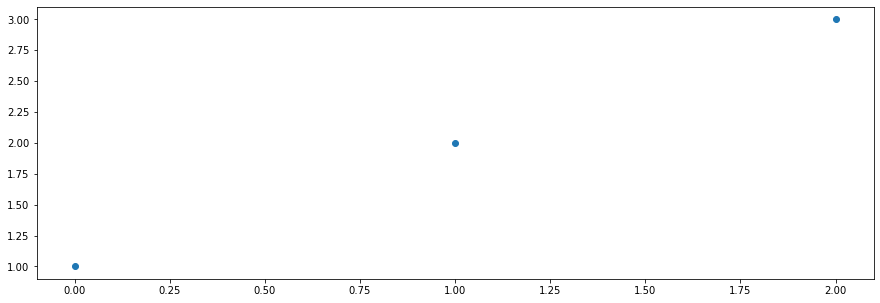

In [30]:
plt.figure(figsize=(15,5))
plt.plot([1,2,3],'o')

In [ ]:
PATH = './CNN_dmrs.state'
torch.save(net.state_dict(), PATH)

In [95]:
plt.figure(figsize=(128/4,4))


<Figure size 2304x288 with 0 Axes>

<Figure size 2304x288 with 0 Axes>